
# ARIMA: Autoregressive Integrated Moving Average

## By Team Fourier
CS189 Project T Final

This notebook will provide an introduction into ARIMA, short for autoregressive integrated moving average. ARIMA models aim to model time series data such as the weather, stock prices, or product sales over a period of time. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

import datetime as dt

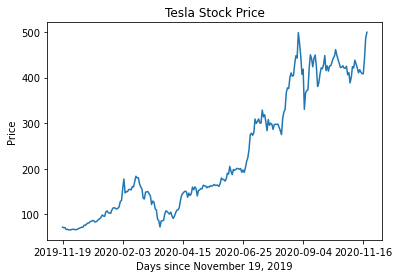

In [2]:
data = pd.read_csv('TSLA.csv')
time = np.array(data['Date'])
price = np.array(data['Close'])

plt.title('Tesla Stock Price')
plt.plot(time, price)
plt.xticks(time[::50])
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()

For example, the graph above depicts the stock price of TSLA over time. The x-axis being time and the y-axis being f(t), the price at that point in time.

Clearly a basic linear model wouldn't be able to model such a function of time due to its non-linearity. However, we have previously learned ways to fit non-linear functions with linear regression using feature lifting. Maybe lifting some polynomial features might help?

## Trying Linear Regression

Linear features, linear regression

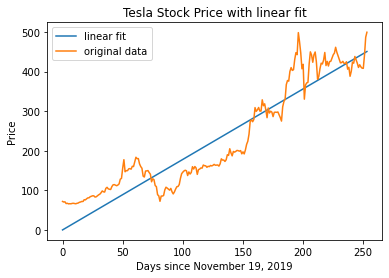

In [3]:
time_steps = np.arange(0, time.shape[0], 1).astype(np.int).reshape((time.shape[0], 1))
w = np.linalg.lstsq(time_steps, price)[0]

plt.plot(time_steps, w * time_steps, label='linear fit')
plt.plot(time_steps, price, label = 'original data')
plt.legend()
plt.title('Tesla Stock Price with linear fit')
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()


Polynomial features, linear regression

(254, 1)
(254, 1)
(254, 1)
[ 3.44395038e+00 -3.09653998e-02  1.14571193e-04  2.30870200e-08
  1.37284610e-09  2.91797474e-09  1.41654546e-11  4.36450870e-09
  1.34465989e-09 -1.69435338e-09  2.39175897e-09 -1.47113220e-10
  2.36191155e-09  8.18078658e-11  5.35648528e-10  5.11201806e-10
  8.24412264e-10 -1.18915243e-09  3.71849475e-09 -1.36811714e-09
  3.55494750e-09  1.36119468e-09  2.50493443e-09  1.61425404e-09
 -2.12319168e-09 -3.33368636e-09 -2.25002198e-09  3.00445385e-09
 -5.03979991e-09 -3.04932521e-09 -3.09367943e-09  6.51673968e-09
 -6.98808583e-10 -1.97545827e-09 -1.80077489e-09  2.86099433e-09
  2.63441686e-10 -2.44091462e-09 -3.13838616e-09  4.43743052e-09
 -4.93992868e-09  6.69869882e-09  2.37976412e-09  3.16317077e-09
 -9.21933130e-10  4.07845046e-10  3.02247159e-09 -4.75411235e-09
  5.60823776e-09  2.90565360e-09]


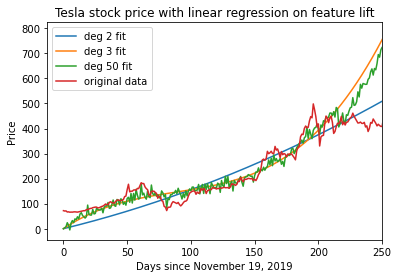

Training error with degree 2 features: [486889.1676851]
Training error with degree 3 features: [292701.38673616]
Training error with degree 50 features: [221481.69154718]


In [4]:
def feature_lift(X, d=2):
    """
    This function computes second order variables
    for polynomial regression.
    Input:
    X: Independent variables.
    Output:
    A data matrix composed of both first and second order terms.
    """
    
    X = np.array(X)
    
    print(X.shape)
    
    X_data = []
    
    for deg in range(1, d+1):
        X_data.append(np.power(X, deg))
        
    return np.hstack(X_data)

second_order_time_steps = feature_lift(time_steps, d=2)
w_2, err_2, _, _ = np.linalg.lstsq(second_order_time_steps[:210], price[:210])

third_order_time_steps = feature_lift(time_steps, d=3)
w_3, err_3, _, _ = np.linalg.lstsq(third_order_time_steps[:220], price[:220])

fifty_order_time_steps = feature_lift(time_steps, d=50)
w_50, err_50, _, _ = np.linalg.lstsq(fifty_order_time_steps[:220], price[:220])

print(w_50)


plt.plot(time_steps, second_order_time_steps @ w_2.T, label='deg 2 fit')
plt.plot(time_steps, third_order_time_steps @ w_3.T, label='deg 3 fit')
plt.plot(time_steps, fifty_order_time_steps @ w_50.T, label='deg 50 fit')
plt.plot(time_steps, price, label = 'original data')

plt.xlim(right=250)
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.legend()
plt.title('Tesla stock price with linear regression on feature lift')
plt.show()

print('Training error with degree 2 features: %s' % str(err_2))
print('Training error with degree 3 features: %s' % str(err_3))
print('Training error with degree 50 features: %s' % str(err_50))

Basically, any attempt to fit some sort of function using linear regression and feature lifting will be met with failure. Why? This is due to the nature of time series data. The problem that linear regressions try to solve is fitting some function to the data in its entirety. However, time series data, such as stock prices don't operate under the same assumptions. Does the stock price 1 year ago directly affect the stock price tomorrow? The answer is, not really. This understanding that only the previous n' << n observations are truly important to our model spawns this set of models that utilize the moving average, the first MA model, then the ARMA, and ARIMA models.

# Formulation of the ARIMA Model

The mathematical model behind ARIMA is:

\begin{align*}
ARIMA(p, d, q) = (1 - \phi_{1}L - \phi_{2}L^{2} - \phi_{3}L^{3}... - \phi_{p}L^{p}) (1 - L)^{d} y_{t} = c + (1 + \theta_{1} L + \theta_{2} L^{2}... + \theta_{q} L^{q}) \epsilon_{t}
\end{align*}

The L is the lag operator, $L^d y_{t} = y_{t - d}$.

The first group of terms, containing $\phi$'s, are the auto-regressive terms. Auto-regressive refers to the contribution of previous observations on the current observation. The parameter $p$ is the number of previous observations looked at. The $\phi$'s are their individual weighting. Intuitively, an observation 1 time step ago usually holds more weight than an observation 10 time steps ago.

The second term, $(1 - L)^{d}$, is the integrated term. This is the term that implements the idea of differencing, which is sometimes necessary to find a deeper relationship in the data. The time series function may not be able to model the observation themselves, but may be able to model the difference between successive observations.

The third and final term, containing $\theta$'s, represent the moving average portion of the model. This is the contribution of the previous $q$ terms, specifically their residuals to the residual at time t. The residuals, $\epsilon_{t}$, are standard normal distribution deviations of each observation from the predicted observation predicted by the model. These residuals are what we try to minimize when fitting parameters to the training data.

The constant c quantifies the drift of the model.

# Breaking Down the ARIMA Model

## Auto-Regressive (AR)

One of the fundamental building blocks of the ARIMA model is the AR portion of the model. The equation for a simple AR model is:

\begin{align*}
AR(p) = y_{t} = c + (\phi_{1}L + \phi_{2}L^{2} + \phi_{3}L^{3}... + \phi_{p}L^{p})y_{t} + \epsilon_{t}
\end{align*}

This equation can already begin to model functions under the assumption that current observations are simply derived from a linear combination of the p previous observations.



For the rest of this notebook, we'll be working with weather data instead of stock data.

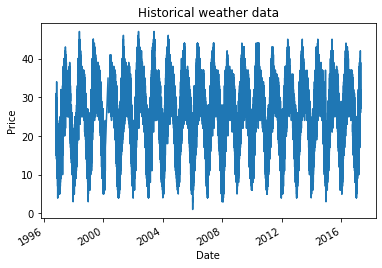

datetime_utc
1996-11-01 11:00:00    30.0
1996-11-01 12:00:00    28.0
1996-11-01 13:00:00    24.0
1996-11-01 14:00:00    24.0
1996-11-01 16:00:00    23.0
Name: temperature, dtype: float64
Null values: 0


In [5]:
#load dataset
weather_data = pd.read_csv('weather_data.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_data = weather_data.rename(index=str, columns={' _tempm': 'temperature'})

#interpolate null values
weather_data.ffill(inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

#remove outliers
weather_data = weather_data[weather_data.temperature < 50]
weather_temp = weather_data['temperature']

weather_temp.plot()
plt.xlabel('time')
plt.ylabel('temp in deg C')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical weather data')
plt.show()

print(weather_temp.head())
print('Null values: %s' % str(weather_temp.isnull().sum()))

The first thing we do with our data is clean it, interpolating null values and making sure the samples are evenly spaced. Next, there are some things we can check about the data itself to ensure it is suitable for an ARIMA model.

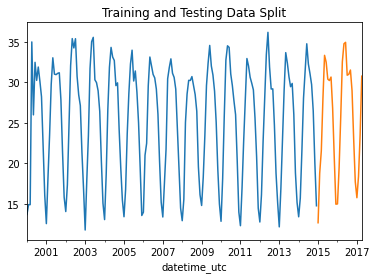

In [6]:
training_data = weather_temp['2000':'2014'].resample('M').mean().fillna(method='pad')
testing_data = weather_temp['2015':'2017'].resample('M').mean().fillna(method='pad')
training_data.plot()
testing_data.plot()
plt.title('Training and Testing Data Split')
plt.show()

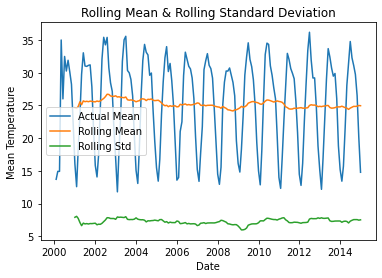

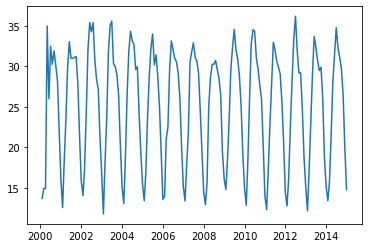

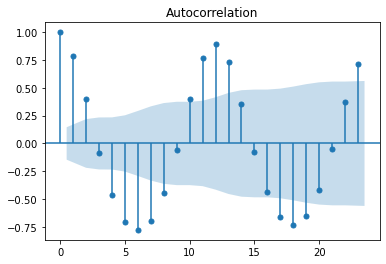

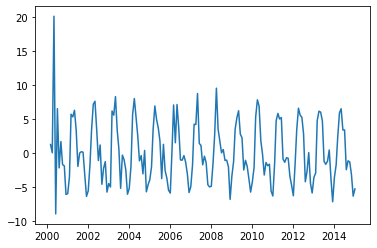

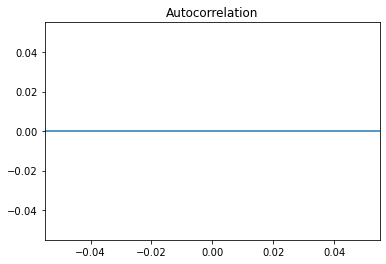

In [7]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

plot_rolling_mean_std(training_data)
    
plt.plot(training_data)
plot_acf(training_data)
plt.show()

plt.plot(training_data.diff())
plot_acf(training_data.diff().values)
plt.show()


We see from the rolling mean and rolling standard deviation plot that the data has a constant mean and standard deviation on a 12 month period. This periodicity implies that our data is seasonal, meaning a standard ARIMA model will have trouble fitting it, but instead we will need to use the seasonal aspect of SARIMA to fit the data.

First, we will try to see what kind of model we retrieve from an AR model.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  180
Model:                     ARMA(4, 0)   Log Likelihood                -443.169
Method:                       css-mle   S.D. of innovations              2.815
Date:                Sun, 22 Nov 2020   AIC                            898.338
Time:                        01:08:27   BIC                            917.495
Sample:                             0   HQIC                           906.105
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1769      0.412     61.128      0.000      24.370      25.984
ar.L1.y        0.9763      0.075     13.051      0.000       0.830       1.123
ar.L2.y        0.0084      0.099      0.085      0.9

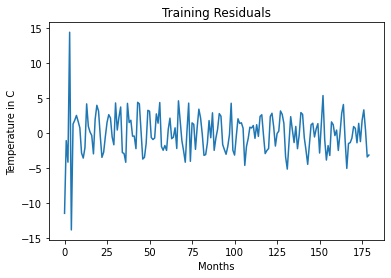

Mean squared training error: 8.569417315817905


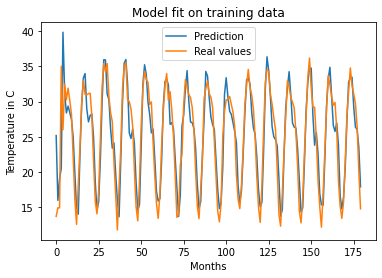

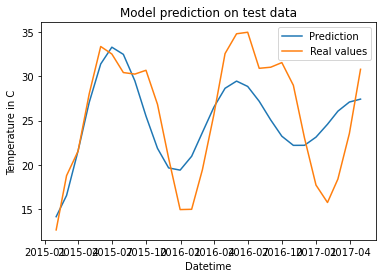

Mean squared testing error: 20.6343968590941


In [9]:
def process_result(res, model='arima'):
    print(res.summary())
    
    plt.plot(res.resid)
    plt.title('Training Residuals')
    plt.xlabel('Months')
    plt.ylabel('Temperature in C')
    plt.show()

    print('Mean squared training error: %s' % str(np.square(res.resid).mean()))

    plt.plot(res.predict(), label='Prediction')
    plt.plot(training_data.values, label='Real values')
    plt.legend()
    plt.title('Model fit on training data')
    plt.xlabel('Months')
    plt.ylabel('Temperature in C')
    plt.show()
    
    if model == 'arima':
        fc, se, conf = res.forecast(testing_data.shape[0], alpha=0.05)
    elif model == 'sarimax':
        fc = res.forecast(testing_data.shape[0], alpha=0.05)
        
    fc_series = pd.Series(fc, index=testing_data.index)
    plt.plot(fc_series, label='Prediction')
    plt.plot(testing_data, label='Real values')
    plt.legend()
    plt.title('Model prediction on test data')
    plt.xlabel('Datetime')
    plt.ylabel('Temperature in C')
    plt.show()
    
    #TODO: Calculate the mean squared testing error
    squared_testing_error = np.square(fc - testing_data).mean()
    print('Mean squared testing error: %s' % str(squared_testing_error))

#use ARIMA(data, order).fit() to generate an AR model fit using order=(p, 0, 0)
#Hint: try p > 1
res = ARIMA(training_data.values, order=(4, 0, 0)).fit()
process_result(res)


### Write down your observations.

How does the model perform on the training data?

How does the model perform on the forecasting of future data?

Why does the AR model not fit this seasonal data well?

## Moving Average (MA)

Another fundamental building block of the ARIMA model is the MA portion of the model. The equation for a simple MA model is:

\begin{align*}
MA(q) = y_{t} = c + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q}
\end{align*}

This equation models the assumption that the residual, the deviation from the predicted point, of the current observation is a linear combination of the previous q residuals.

Add the moving average section of the ARIMA model, and model the weather data using an ARMA model.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  180
Model:                     ARMA(2, 2)   Log Likelihood                -427.374
Method:                       css-mle   S.D. of innovations              2.570
Date:                Sun, 22 Nov 2020   AIC                            866.747
Time:                        01:08:29   BIC                            885.905
Sample:                             0   HQIC                           874.515
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2027      0.126    199.485      0.000      24.955      25.450
ar.L1.y        1.6794      0.025     68.178      0.000       1.631       1.728
ar.L2.y       -0.9528      0.024    -40.304      0.0

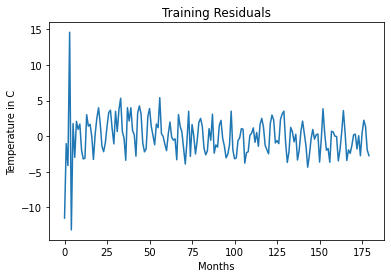

Mean squared training error: 7.649049707253839


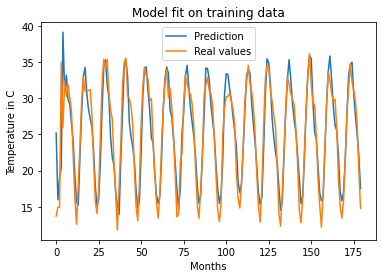

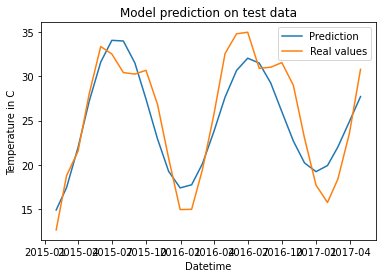

Mean squared testing error: 8.853190571694395


In [10]:
#use ARIMA(data, order).fit() to generate an ARMA model fit using order=(p, 0, q)
#Hint: try p, q > 1
res = ARIMA(training_data.values, order=(2, 0, 2)).fit()
process_result(res)

### Write down your observations.

How does the model perform on the training data?

How does the model perform on the forecasting of future data?

Does the ARMA model fit the seasonal data better than the AR model?

# Seasonality in ARIMA: SARIMA

As we noted in the weather data, we see a seasonal pattern, or period with fixed period length. The traditional ARIMA model is not fully suited to model this behavior, but this is where SARIMA comes into play. SARIMA, season auto-regressive integrated moving average, has a slightly different formulation from ARIMA:

\begin{align*}
SARIMA(p, d, q) (P, D, Q)_{m} = (1 - \phi_{1}L - \phi_{2}L^{2} - \phi_{3}L^{3}... - \phi_{p}L^{p}) (1 - \Phi_{1}L^{m} - \Phi_{2}L^{2m} - \Phi_{3}L^{3m}... - \Phi_{P}L^{Pm}) (1 - L)^{d} (1 - L)^{Dm} y_{t} = c + (1 + \theta_{1} L + \theta_{2} L^{2}... + \theta_{q} L^{q}) (1 + \Theta_{1} L^{m} + \Theta_{2} L^{2m}... + \Theta_{Q} L^{Qm}) \epsilon_{t}
\end{align*}

The seasonal terms are terms that operate much like the original ARIMA terms, but the lag operators are all raised to the power of $m$, in the case of the annual cycle of weather data, $m=12$, meaning the model takes into account observations from 12, 24, 36.... months ago.

Implement a SARIMA model on the weather data.

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  180
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                -389.026
Date:                             Sun, 22 Nov 2020   AIC                            790.052
Time:                                     01:08:31   BIC                            809.210
Sample:                                          0   HQIC                           797.820
                                             - 180                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0313      0.023      1.347      0.178      -0.014       0.077
ar.L2          0.9685      

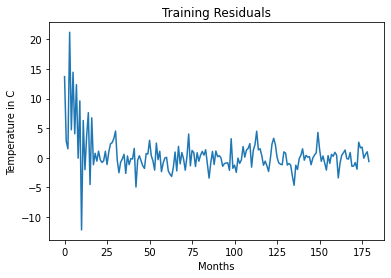

Mean squared training error: 10.607873349210044


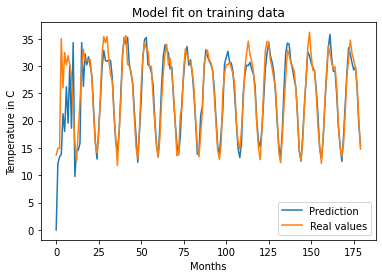

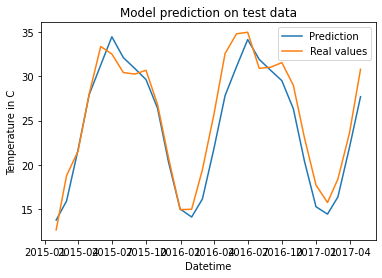

Mean squared testing error: 4.594738756786617


In [11]:
res = SARIMAX(training_data.values, order=(2, 0, 2), seasonal_order=(1, 0, 0, 12)).fit()
process_result(res, 'sarimax')

### Write down your observations.

How does the model perform on the training data?

How does the model perform on the forecasting of future data?

Does the SARIMAX model fit the seasonal data better than the ARIMA model?

# Hyperparameters

You may have noticed that sometimes the performance is better than other times when using different values for p, d, q, P, D, and Q. These values are called hyperparameters, hand selected values by the engineer creating the model that greatly influence the effectiveness of the model. There are several ways to set these hyperparameters, as discussed earlier in this course. You can employ techniques such as k-fold cross validation and grid searches, as well as use domain knowledge to make educated guesses on what we want the model to learn and what the underlying model in reality is. For example, someone with strong knowledge of the weather can make a better educated guess about how many days one should look back in the past to predict today's weather.

First, make a guess based on what you think influences the weather. What are good values for p, d, q, P, D, and Q? 

Hint: Don't use d or D, differencing leads to a very bad result in this dataset.

Run a SARIMAX model with your guess here:

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -366.885
Date:                            Sun, 22 Nov 2020   AIC                            751.771
Time:                                    01:08:37   BIC                            780.507
Sample:                                         0   HQIC                           763.422
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7397      0.173      4.281      0.000       0.401       1.078
ar.L2          0.2431      0.171   

c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


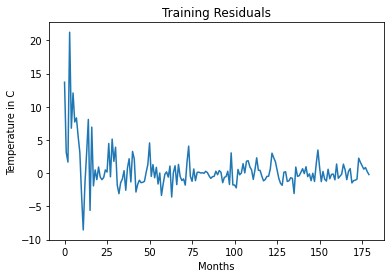

Mean squared training error: 8.96511692974023


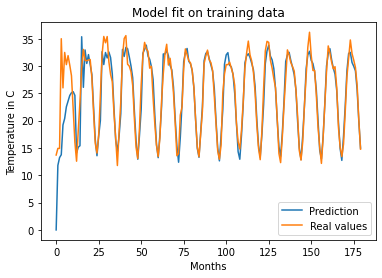

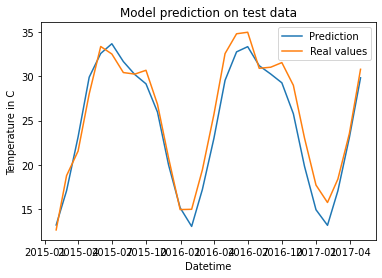

Mean squared testing error: 3.2735343012303146


In [12]:
#TODO run a SARIMAX model with your guess
res = SARIMAX(training_data.values, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12)).fit()
process_result(res, 'sarimax')

Now, let's try using a grid search to find the best parameters.

In [ ]:
def get_test_mse(res):
   #todo calculate test mse  
    fc = res.forecast(testing_data.shape[0], alpha=0.05)
    squared_testing_error = np.square(fc - testing_data).mean()
    return squared_testing_error

p_range = list(range(4))
q_range = list(range(4))
P_range = list(range(4))
Q_range = list(range(4))

best_params = (-1, -1, -1, -1)
best_test_mse = 10000000

#todo use a grid search to find the best parameters
for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    res = SARIMAX(training_data.values, order=(p, 0, q), seasonal_order=(P, 0, Q, 12), maxiter = 5).fit()
                    test_mse = get_test_mse(res)
                    if test_mse < best_test_mse:
                        best_params = (p, q, P, Q)
                        best_test_mse = test_mse
                    print('Tested params:', p, q, P, Q)
                except:
                    pass
                
                
print('Best parameters: ', best_params)
res = SARIMAX(training_data.values, order=(best_params[0], 0, best_params[1]), seasonal_order=(best_params[2], 0, best_params[3], 12)).fit()
process_result(res, 'sarimax')

Tested params: 0 0 0 0
Tested params: 0 0 0 1
Tested params: 0 0 0 2
Tested params: 0 0 0 3
Tested params: 0 0 1 0
Tested params: 0 0 1 1
Tested params: 0 0 1 2
Tested params: 0 0 1 3
Tested params: 0 0 2 0
Tested params: 0 0 2 1
Tested params: 0 0 2 2
Tested params: 0 0 2 3
Tested params: 0 0 3 0
Tested params: 0 0 3 1
Tested params: 0 0 3 2
Tested params: 0 0 3 3
Tested params: 0 1 0 0
Tested params: 0 1 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 1 0 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 1 0 3
Tested params: 0 1 1 0
Tested params: 0 1 1 1
Tested params: 0 1 1 2
Tested params: 0 1 1 3
Tested params: 0 1 2 0
Tested params: 0 1 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 1 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 1 2 3
Tested params: 0 1 3 1
Tested params: 0 1 3 2
Tested params: 0 2 0 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 0 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 0 3
Tested params: 0 2 1 0
Tested params: 0 2 1 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 1 3
Tested params: 0 2 2 0
Tested params: 0 2 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 2 3
Tested params: 0 2 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 3 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 2 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 0 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 0 1
Tested params: 0 3 0 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 0 3
Tested params: 0 3 1 0
Tested params: 0 3 1 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 1 3
Tested params: 0 3 2 0
Tested params: 0 3 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 2 3
Tested params: 0 3 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 3 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 0 3 3 2
Tested params: 1 0 0 0
Tested params: 1 0 0 1
Tested params: 1 0 0 2
Tested params: 1 0 0 3
Tested params: 1 0 1 0
Tested params: 1 0 1 1
Tested params: 1 0 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 0 1 3
Tested params: 1 0 2 0
Tested params: 1 0 2 1
Tested params: 1 0 2 2
Tested params: 1 0 2 3
Tested params: 1 0 3 0
Tested params: 1 0 3 1
Tested params: 1 0 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 0 3 3
Tested params: 1 1 0 0
Tested params: 1 1 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 1 0 2
Tested params: 1 1 0 3
Tested params: 1 1 1 0
Tested params: 1 1 1 1
Tested params: 1 1 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 1 1 3
Tested params: 1 1 2 0
Tested params: 1 1 2 1
Tested params: 1 1 2 2
Tested params: 1 1 2 3
Tested params: 1 1 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 1 3 1
Tested params: 1 1 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 1 3 3
Tested params: 1 2 0 0
Tested params: 1 2 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 0 2
Tested params: 1 2 0 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 1 0
Tested params: 1 2 1 1
Tested params: 1 2 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 1 3
Tested params: 1 2 2 0
Tested params: 1 2 2 1
Tested params: 1 2 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 2 3
Tested params: 1 2 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 3 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 2 3 2
Tested params: 1 2 3 3
Tested params: 1 3 0 0
Tested params: 1 3 0 1
Tested params: 1 3 0 2
Tested params: 1 3 0 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 1 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 1 1
Tested params: 1 3 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 1 3
Tested params: 1 3 2 0
Tested params: 1 3 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 2 2
Tested params: 1 3 2 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 3 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 1 3 3 3
Tested params: 2 0 0 0
Tested params: 2 0 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 0 0 2
Tested params: 2 0 0 3
Tested params: 2 0 1 0
Tested params: 2 0 1 1
Tested params: 2 0 1 2
Tested params: 2 0 1 3
Tested params: 2 0 2 0
Tested params: 2 0 2 1
Tested params: 2 0 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 0 2 3
Tested params: 2 0 3 0
Tested params: 2 0 3 1
Tested params: 2 1 0 0
Tested params: 2 1 0 1
Tested params: 2 1 0 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 1 0 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 1 1 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 1 1 1
Tested params: 2 1 1 2
Tested params: 2 1 1 3
Tested params: 2 1 2 0
Tested params: 2 1 2 1
Tested params: 2 1 2 2
Tested params: 2 1 2 3
Tested params: 2 1 3 0
Tested params: 2 1 3 1
Tested params: 2 1 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 1 3 3
Tested params: 2 2 0 0
Tested params: 2 2 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 0 2
Tested params: 2 2 0 3
Tested params: 2 2 1 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 1 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 2 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 3 0
Tested params: 2 2 3 1
Tested params: 2 2 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 2 3 3
Tested params: 2 3 0 0
Tested params: 2 3 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 0 2
Tested params: 2 3 0 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 1 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 1 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 1 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 1 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 2 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 2 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 3 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 2 3 3 3
Tested params: 3 0 0 0
Tested params: 3 0 0 1
Tested params: 3 0 0 2
Tested params: 3 0 0 3
Tested params: 3 0 1 0
Tested params: 3 0 1 1
Tested params: 3 0 1 2
Tested params: 3 0 1 3
Tested params: 3 0 2 0
Tested params: 3 0 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 0 2 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 0 2 3
Tested params: 3 0 3 0


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 0 3 1
Tested params: 3 0 3 2


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 0 3 3
Tested params: 3 1 0 0
Tested params: 3 1 0 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 1 0 2
Tested params: 3 1 0 3


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 1 1 0
Tested params: 3 1 1 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 1 1 2
Tested params: 3 1 1 3
Tested params: 3 1 2 0
Tested params: 3 1 2 1


c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tested params: 3 1 2 2


That probably took a while, was it worth it?

## Observations

How did the grid search perform compared to your guess?